# ARIMA 时序数据预测模型

## 导入Python库和样本数据集

In [2]:
# 导入相关依赖库
import time
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 默认设置
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

可从数据集市DataMarket下载数据集：国际航线乘客数月度数据，保存为CSV格式文件"international-airline-passengers.csv"
(https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) 

In [3]:
# 加载CSV数据
data = pd.read_csv('data.csv', engine='python', skipfooter=3)
data

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [4]:
# 数据集预处理
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)

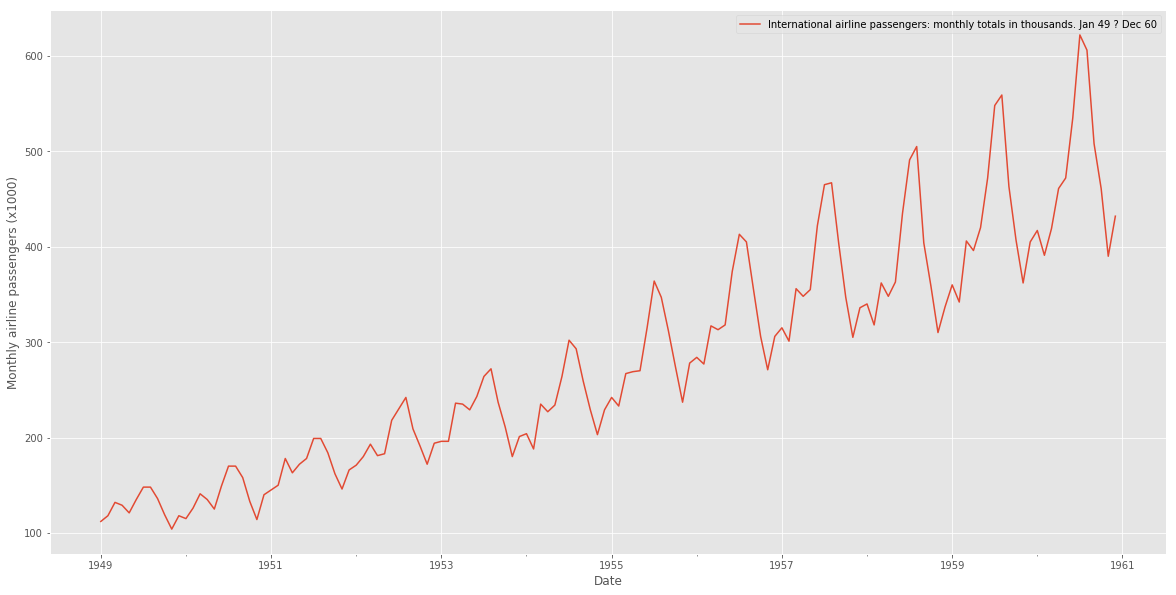

In [5]:
# 用Plot绘制数据集
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

数据中出现两种明显的迹象，随着时间的推移，乘客数量总体增加，12个月的季节性维度峰值出现在夏季6，7月份。

## ARIMA
ARIMA代表自动回归综合移动平均线。 有三个整数（p，d，q）用于参数化ARIMA模型。 ARIMA模型用ARIMA（p，d，q）表示：
<ul>
<li><strong>p</strong> 是自回归项的数量（AR部分）。 它将过去值的影响结合到模型中。 例如：如果在过去的3天里一直很温暖，那么明天可能会很温暖。</li>
<li><strong>d</strong> 是平稳性所需的非季节性差异的数量。 例如：如果过去三天的温度差异非常小，那么明天可能会出现相同的温度。
</li>
<li><strong>q</strong> 是预测中滞后预测误差的数量（MA部分）。 这允许将模型的误差设置为过去在先前时间点观察到的误差值的线性组合。
</li>
</ul>

在处理季节性效应时，使用的季节性ARIMA，其表示为ARIMA（p，d，q）（P，D，Q）s。 这里，（p，d，q）是上述非季节性参数， (<strong>P, D, Q</strong>) 遵循相同的定义，但是应用于时间序列的季节性分量。术语 <strong>s</strong> 时间序列的周期性。

样例数据场景(国际航线乘客月度数) 中 s=12, 其他两个参数该如何设置? 基本上是基于经验，可以遵循许多最佳实践来识别ARIMA模型：
http://people.duke.edu/~rnau/arimrule.htm.

在这里，我们使用网格搜索在预定义的值范围内的所有可能的参数值组合，参考：
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ 返回 AIC (Akaike Information Criterion) 和 BIC (Bayes Information Criterion) 可以将其最小化以选择最佳拟合模型。使用AIC值，该值估计当给定模型用于表示生成数据的过程时丢失的信息。 在这样做时，它处理模型的拟合优度和模型本身的复杂性之间的权衡。

使用AIC值，该值估计当给定模型用于表示生成数据的过程时丢失的信息。 在这样做时，它处理模型的拟合优度和模型本身的复杂性之间的权衡。

In [6]:
# 定义d和q参数以获取0到1之间的任何值
q = d = range(0, 2)
# 定义p参数以获取0到3之间的任何值
p = range(0, 4)

# 生成p，q和q的所有不同组合
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1),
 (2, 0, 0),
 (2, 0, 1),
 (2, 1, 0),
 (2, 1, 1),
 (3, 0, 0),
 (3, 0, 1),
 (3, 1, 0),
 (3, 1, 1)]

In [7]:
# 生成季节性p，q和q三元组的所有不同组合
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('季节性ARIMA的参数组合示例')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

季节性ARIMA的参数组合示例
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


选择国际航线乘客数月度数据的一个子集作为训练集，比如前11年。目标是根据这一输入预测后面年份每个月的国际航线乘客数。

In [8]:
# 训练集
train_data = data['1949-01-01':'1959-12-01']
train_data

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [9]:
# 测试集，这里是真实的数据值，充当标记lable，用于对比预测值进行误差分析。
test_data = data['1960-01-01':'1960-12-01']
test_data

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [11]:
# 忽略警告消息
warnings.filterwarnings("ignore") 

# 计算AIC参数, 根据训练数据集的大小和参数范围选择耗时不同。
start = time.time()

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue
            
'%.2f sec' % (time.time() - start)

'215.52 sec'

In [20]:
print('最小 AIC 值为: {} 对应模型参数: SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

最小 AIC 值为: 618.2055110471625 对应模型参数: SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [21]:
# 使用训练数据拟合模型
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

一旦模型拟合，就可以输入训练数据集输出预测值，观察模型的输出值与训练数据集中的真实结果之间的偏差是否符合要求。 

## 进行预测

In [22]:
pred = results.get_forecast('1962-12-01')
pred_ci = pred.conf_int()
print(pred.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.495187
1960-02-01    397.834263
1960-03-01    460.859184
1960-04-01    449.452088
1960-05-01    474.555955
1960-06-01    537.849066
1960-07-01    614.885097
1960-08-01    628.209420
1960-09-01    519.336762
1960-10-01    462.254866
1960-11-01    412.164423
1960-12-01    452.665134
Freq: MS, dtype: float64


测试数据集的真实结果为：

In [15]:
test_data

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


通过plot绘图显示预测效果

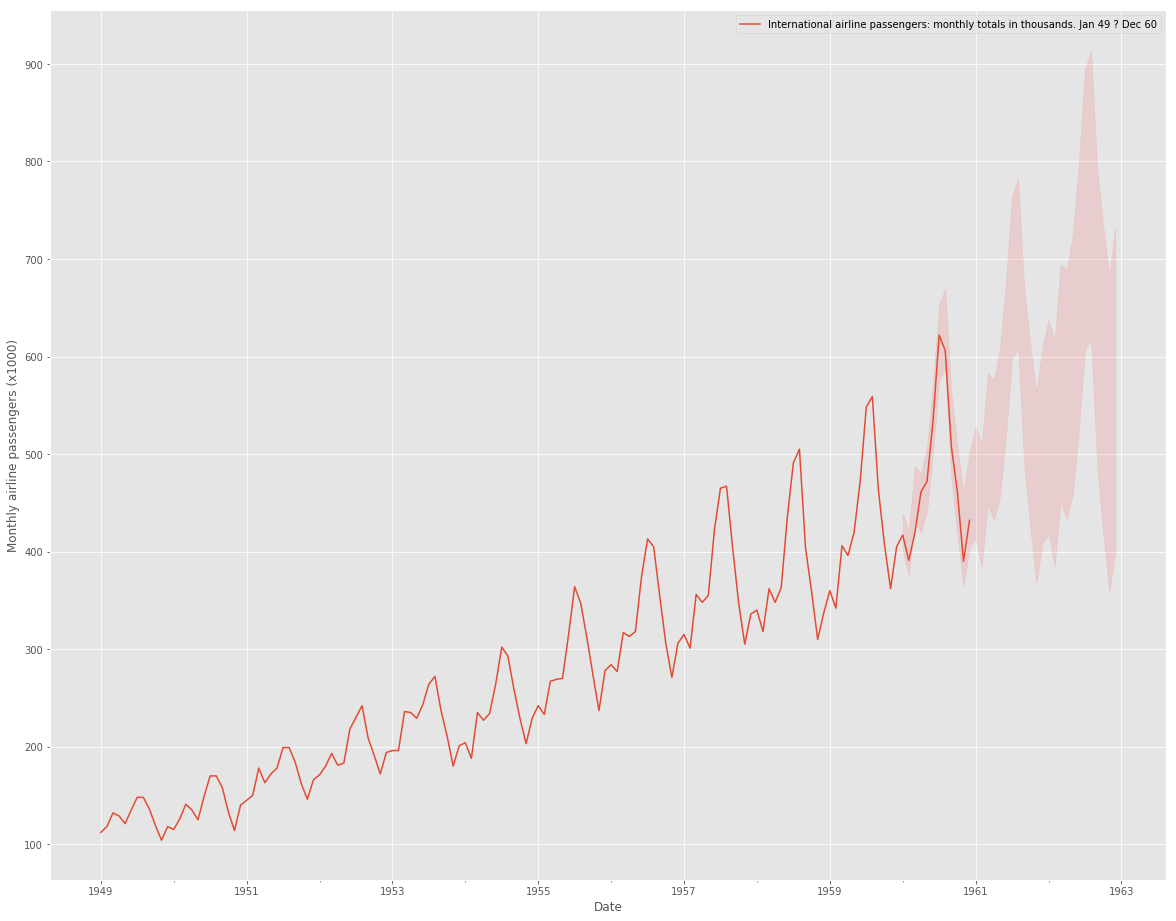

In [23]:
ax = data.plot(figsize=(20, 16))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='R', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

误差率计算：

In [24]:
prediction = pred.predicted_mean['1960-01-01':'1960-12-01'].values
# 合并样本数据中测试集嵌套列表
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('1960年预测的平均绝对百分比误差是 {:.2f}%'.format(MAPE))

1960年预测的平均绝对百分比误差是 2.81%
